# Mango Attribute Predict Model

### Imports

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython import get_ipython
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
import missingno as msno

### Data Preprocessing

In [18]:
df = pd.read_csv("../datathon-fme-mango/archive/product_data.csv")
attribute_data = pd.read_csv("../datathon-fme-mango/archive/attribute_data.csv")
print(df.head(), attribute_data.head())

  cod_modelo_color cod_color des_sex des_age des_line des_fabric  \
0       83_1124642        82  Female    Kids     KIDS     TRICOT   
1       86_1215223        01  Female    Kids     KIDS      WOVEN   
2       84_1167695        70  Female    Kids     KIDS   CIRCULAR   
3       82_1108473        01  Female    Teen     KIDS      JEANS   
4       83_1137778        37    Male   Adult      MAN   CIRCULAR   

                  des_product_category des_product_aggregated_family  \
0                                 Tops        Sweaters and Cardigans   
1  Dresses, jumpsuits and Complete set         Dresses and jumpsuits   
2                                 Tops                      T-shirts   
3                              Bottoms                         Jeans   
4                                 Tops        Sweaters and Cardigans   

  des_product_family des_product_type                  des_filename  \
0            Sweater          Sweater  83_1124642_17074019-82_B.jpg   
1            Dre

In [19]:
df.describe()

,cod_modelo_color,cod_color,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_filename,des_color
count,61484,61366,61484,61484,61484,61484,61484,61484,61484,61484,61484,61366
unique,33443,121,3,5,3,7,5,11,26,47,61484,121
top,83_1124642,99,Female,Adult,WOMAN,WOVEN,Tops,T-shirts,T-shirt,T-Shirt,83_1124642_17074019-82_B.jpg,NEGRO
freq,2,9755,43129,45905,33618,24336,28825,10291,9166,9166,1,9755


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61484 entries, 0 to 61483
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   cod_modelo_color               61484 non-null  object
 1   cod_color                      61366 non-null  object
 2   des_sex                        61484 non-null  object
 3   des_age                        61484 non-null  object
 4   des_line                       61484 non-null  object
 5   des_fabric                     61484 non-null  object
 6   des_product_category           61484 non-null  object
 7   des_product_aggregated_family  61484 non-null  object
 8   des_product_family             61484 non-null  object
 9   des_product_type               61484 non-null  object
 10  des_filename                   61484 non-null  object
 11  des_color                      61366 non-null  object
dtypes: object(12)
memory usage: 5.6+ MB


In [21]:
# Pivot the attribute_data dataframe
attribute_pivot = attribute_data.pivot(index='cod_modelo_color', columns='attribute_name', values='des_value')

# Reset the index to merge with df
attribute_pivot.reset_index(inplace=True)

# Merge the pivoted attribute data with the product data
df = pd.merge(df, attribute_pivot, on='cod_modelo_color', how='left')

# Display the merged dataframe
print(df_merged.head())

  cod_modelo_color cod_color des_sex des_age des_line des_fabric  \
0       83_1124642        82  Female    Kids     KIDS     TRICOT   
1       86_1215223        01  Female    Kids     KIDS      WOVEN   
2       84_1167695        70  Female    Kids     KIDS   CIRCULAR   
3       82_1108473        01  Female    Teen     KIDS      JEANS   
4       83_1137778        37    Male   Adult      MAN   CIRCULAR   

                  des_product_category des_product_aggregated_family  \
0                                 Tops        Sweaters and Cardigans   
1  Dresses, jumpsuits and Complete set         Dresses and jumpsuits   
2                                 Tops                      T-shirts   
3                              Bottoms                         Jeans   
4                                 Tops        Sweaters and Cardigans   

  des_product_family des_product_type  ... closure_placement heel_shape_type  \
0            Sweater          Sweater  ...            Cuello             NaN  

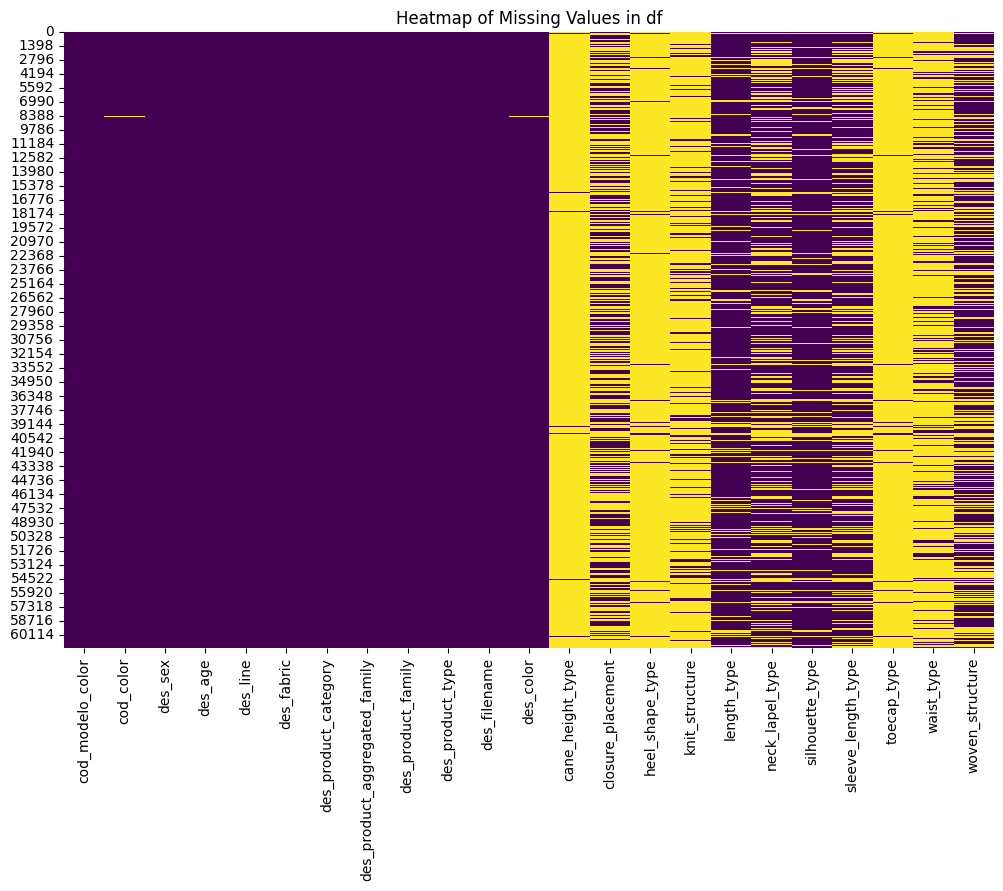

In [22]:
# Check for missing values in the dataframe
missing_values = df.isnull().sum()

# Create a heatmap of the missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values in df')
plt.show()